In [1]:
import numpy as np
import matplotlib.pyplot as plt

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from helpers import compute_ridge_loss
from helpers import *
from implementations import *
from preprocessing import *

In [2]:
np.random.seed(2020)

## Load Datasets


In [3]:
p = Preprocessing(load_csv('../dataset/trainset.csv'))
y_train , x_train= p.preprocess()
p = Preprocessing(load_csv('../dataset/testset.csv'))
y_test, x_test = p.preprocess()

In [4]:
print(x_train.shape)
print(x_test.shape)

(225000, 31)
(25000, 31)


## Prediction with decision boundary

In [5]:
def predict(weight, x_test, boundary = 0.5):
    """
    # Gives predictions given weight and datapoints 
    
    :param weight: vector weight
    :type weight: 1D array
    
    :param x_test: extended feature matrix
    :type x_test: 2D array
    
    :return: label predictions (0 or 1)
    :rtype:  1D numpy array
    
    """
    
    pred = x_test.dot(weight)
    return (pred > boundary)*1
    

## Ridge Regression on dataset

In [6]:
w, loss = ridge_regression(y_train, x_train,0.004)
print(w) # gives an idea about the important columns.. 
print(w.shape)
print(loss)

[ 3.39876543e-01  2.92215114e-03 -1.25170884e-01 -1.21200506e-01
  3.75508083e-03  1.37591143e-02  4.30769267e-02  3.09171484e-03
  1.34088164e-01 -1.40882957e-02  2.66338549e-02 -8.71212711e-02
  5.88851209e-02  3.77909539e-02  8.54348852e-02  1.65467729e-04
 -3.54879843e-04  1.27488054e-01 -8.40100689e-04  7.48630428e-04
  4.81747423e-02  5.28005644e-04 -2.16649214e-02  1.76743327e-02
 -2.41109249e-02  2.64536026e-04 -1.22418485e-04 -1.83071720e-02
  4.69187461e-04 -2.53235820e-04 -1.67847801e-02]
(31,)
0.0860017342358788


##  Cross Validation

In [7]:
def build_k_indices(y, k_fold):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def K_Cross_Validation(x, y, K, _lambda):
    #Initialization of all needed arrays
    test_loss = np.zeros(K)
    train_loss = np.zeros(K)
    weights = np.zeros((K,x.shape[1]))
    accuracy = np.zeros(K)
    indices = build_k_indices(y, K)
    
    for i in range(K):
        test_indices = indices[i]
        y_test = y[test_indices]
        y_train = np.delete(y,test_indices)
        x_test = x[test_indices,:]
        x_train = np.delete(x,test_indices,axis=0)

        ### ADAPT METHOD & LOSS
        weights[i], train_loss[i] = ridge_regression(y_train, x_train,_lambda)
        test_loss[i] = compute_ridge_loss(y_test,x_test,weights[i],_lambda)
        
        #Calculate predictions of the model
        predictions = predict(weights[i] , x_test)
        #Calculate accuracy of the model
        accuracy[i] = np.sum(predictions == y_test) / len(y_test)
        
    return accuracy, test_loss, train_loss, np.mean(weights, axis=0)
        

0.7436


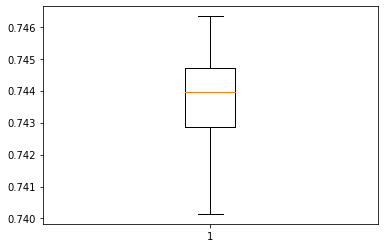

In [8]:
accs,test_loss, train_loss, w = K_Cross_Validation(x_train,y_train,4,0.001)
plt.boxplot(accs)
print(accs.mean())

## Tune Hyperparameters

In [9]:
def Tune_lambda(xt_training, y_training, K, gamma_range):
        
    gammas = np.logspace(-7, gamma_range, 20)
    min_loss = np.inf
    opt_lambda = 0
    opt_index = 0
    accuracies = []
    train_losses = []
    test_losses = []
    for i, lambda_ in enumerate(gammas):
       
        accuracy,test,train,w = K_Cross_Validation(xt_training, y_training, K,lambda_)
        accuracies.append([lambda_,accuracy.mean()])
        train_losses.append([lambda_,train.mean()])
        test_losses.append([lambda_,test.mean()])
        if (test.mean() < min_loss):
            min_loss = test.mean()
            opt_lambda = lambda_
            opt_index = i
                
    return opt_lambda , min_loss, np.array(accuracies), np.array(train_losses), np.array(test_losses), opt_index
opt_lambda, min_loss, acc ,train, test, opt_index= Tune_lambda(x_train, y_train, 5, &)

print(f"optimal loss = {min_loss} with lambda= {opt_lambda}")
print(f"accuracy = {acc[opt_index][1]}")

optimal loss = 0.08518125969150192 with lambda= 3.359818286283781e-05
accuracy = 0.7438355555555556


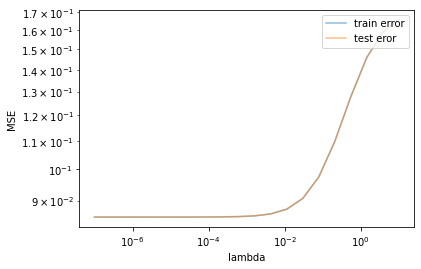

In [20]:

#plt.plot(acc[:,0],acc[:,1], label="accuracy")
plt.plot(train[:,0],train[:,1],alpha=0.5,label="train error")
plt.plot(test[:,0],test[:,1],alpha=0.5, label = "test eror")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.show()

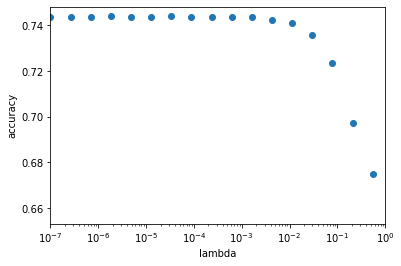

In [24]:
plt.scatter(acc[:,0],acc[:,1])
plt.xscale('log')
plt.xlim(10**(-7),1)
plt.xlabel("lambda")
plt.ylabel('accuracy')
plt.show()

model is clearly **UNDERFITTING**, test and train score are exactly the same and increasing

## predictions on test set 

In [27]:
opt_w,loss = ridge_regression(y_train,x_train,opt_lambda)
opt_w

array([ 3.42572536e-01,  4.73686739e-03, -1.27134922e-01, -1.31142411e-01,
        1.27270809e-03,  1.27927828e-02,  4.46520872e-02,  3.83596537e-03,
        1.40975756e-01, -1.39771487e-02,  2.59520964e-02, -9.34235634e-02,
        5.88911358e-02,  3.80965212e-02,  8.67854877e-02,  2.15400545e-04,
       -2.92120079e-04,  1.38342689e-01, -8.71556012e-04,  7.34870526e-04,
        5.13995378e-02,  4.95029554e-04, -2.30763548e-02,  2.20059796e-02,
       -2.35917675e-02,  2.80353373e-04, -1.44963098e-04, -1.75703349e-02,
        4.62717879e-04, -2.59336839e-04, -2.02642672e-02])

In [31]:
for b in [0.3,0.4,0.5,0.55,0.6,0.65,0.7]:
    p = predict(opt_w,x_test,b)
    print(f"decision boundary={b}")
    print(f"\tconfusion matrix: \n {confusion_matrix(y_test,p)}")
    print(f"\taccuracy={(p==y_test).mean()}")

decision boundary=0.3
	confusion matrix: 
 [[0.60461717 0.39538283]
 [0.1316556  0.8683444 ]]
	accuracy=0.69516
decision boundary=0.4
	confusion matrix: 
 [[0.75464458 0.24535542]
 [0.28230223 0.71769777]]
	accuracy=0.74196
decision boundary=0.5
	confusion matrix: 
 [[0.88048974 0.11951026]
 [0.50297099 0.49702901]]
	accuracy=0.74884
decision boundary=0.55
	confusion matrix: 
 [[0.92251934 0.07748066]
 [0.62320867 0.37679133]]
	accuracy=0.73516
decision boundary=0.6
	confusion matrix: 
 [[0.95321922 0.04678078]
 [0.72806711 0.27193289]]
	accuracy=0.71932
decision boundary=0.65
	confusion matrix: 
 [[0.97356399 0.02643601]
 [0.80741    0.19259   ]]
	accuracy=0.70544
decision boundary=0.7
	confusion matrix: 
 [[0.98373637 0.01626363]
 [0.86554818 0.13445182]]
	accuracy=0.69216
